In [1]:
%load_ext autoreload

In [2]:
import os

os.chdir('..')
!export PYTHONPATH=$(pwd):$PYTHONPATH

import parkinson

import torch
from torch import nn

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [3]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 32
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001
CORR_METHOD = "sliding_window"  # método de matriz de correlação: sliding_window, pearson...(no graph.py)
SAVE_PATH = 'outputs/1_correlation_matrix'

# Processamento dos dados

In [4]:
# lendo os arquivos de dados
parkinson_data = parkinson.utils.data.batch_read('data/PDs_columns')
control_data = parkinson.utils.data.batch_read('data/Controls_columns') 

# selecionando as colunas de atlas AAL3, o atlas de conectividade cerebral
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

# Geração da matriz de correlação utilizando o método especificado para o grupo de Parkinson
parkinson_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(
    parkinson_atlas_data, method=CORR_METHOD, group='parkinson'
)

# Geração da matriz de correlação utilizando o método especificado para o grupo controle
control_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(
    control_atlas_data, method=CORR_METHOD, group='control'
)

# Concatenando grupo controle e grupo de Parkinson
# e filtrando os dados para remover entradas com NaN ou infinitos
X = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])
X, y = parkinson.utils.data.filter_data(X, y)

# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

# Aplicando oversampling no conjunto de treino
ros = RandomOverSampler(random_state=RDN)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Criando DataLoaders
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

100%|██████████| 66/66 [00:01<00:00, 42.76it/s]


# Treinamento

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

out = parkinson.utils.train.train(model, train_loader, val_loader, device, N_EPOCHS, PATIENCE, LR, class_weights=class_weights)

metrics = parkinson.utils.train.evaluate(model, test_loader, device)

train-loss: 0.1758  train-acc: 0.9725 | val-loss: 0.4952  val-acc: 0.7727:  38%|███▊      | 75/200 [00:20<00:34,  3.58it/s]

Early stopping at epoch 76


# Análise dos resultados

 Acurácia       F1  Precisão  Recall
     0.75 0.746984  0.744792    0.75


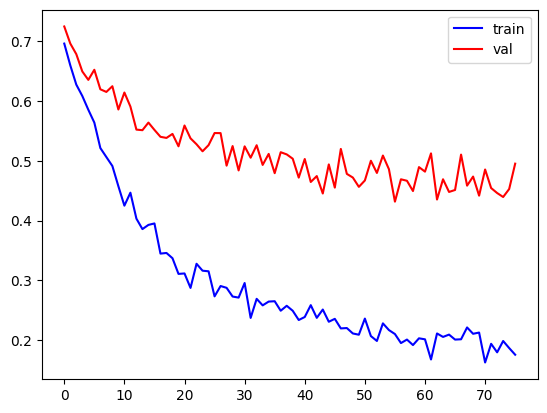

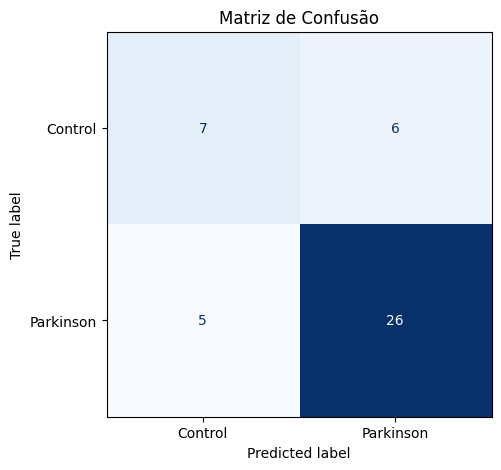

In [6]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'],out['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/loss_curve_{CORR_METHOD}.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix_{CORR_METHOD}.png", bbox_inches='tight')